In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


THe original eddy covariance tower data are downloaded from http://ameriflux.lbl.gov/. Tower data are used to study greenhouse gases

This is half-hour eddy covariance tower dataset with starting/ending time window.
<br>
- Independt variable: air temperature(TA) <br>
- Dependent variable: CO2 flux(FC)<br>


Task:
1. Gap filling the data by its closest date for the same period to fill the value using either nearest neighbor concept or mean of a few nearest neighbor
2. Using IQR method (or +/2.5 STD) to identify outliers for each month and drop the outliers before getting the mean
2. Get monthly mean, and seasoal mean of TA and FC


# Import Data


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime


pd.set_option('display.max_columns', None)

In [12]:
file_path = '/content/drive/MyDrive/Litdesktop/FAU Folder/FAU Projects/Greenhouse Gas Emission/AMF_US-Elm_BASE_HH_4-1.csv'
df = pd.read_csv(file_path)

In [13]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54610 entries, 0 to 54609
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TIMESTAMP_START  54610 non-null  int64  
 1   TIMESTAMP_END    54610 non-null  int64  
 2   TA               54610 non-null  float64
 3   FC               54610 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 1.7 MB


,TIMESTAMP_START,TIMESTAMP_END,TA,FC
0,200807221400,200807221430,33.58,-0.610
1,200807221430,200807221500,34.08,-0.853
2,200807221500,200807221530,32.48,-1.107
3,200807221530,200807221600,32.29,-1.165
4,200807221600,200807221630,32.37,-0.379


In [14]:
df.columns

Index(['TIMESTAMP_START', 'TIMESTAMP_END', 'TA', 'FC'], dtype='object')

In [15]:
# change the datatype to datetime, with format '%Y%m%d%H%M'
df['TIMESTAMP_START'] = pd.to_datetime(df['TIMESTAMP_START'], format='%Y%m%d%H%M')
df['TIMESTAMP_END'] = pd.to_datetime(df['TIMESTAMP_END'], format = '%Y%m%d%H%M')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54610 entries, 0 to 54609
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TIMESTAMP_START  54610 non-null  datetime64[ns]
 1   TIMESTAMP_END    54610 non-null  datetime64[ns]
 2   TA               54610 non-null  float64       
 3   FC               54610 non-null  float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 1.7 MB


In [16]:
# we do not need TIMESTAMP_END, half hour
df.drop(columns = ['TIMESTAMP_END'], inplace =True )

In [17]:
print("It is a half-hour TA and FC measurments from 2008-07-22 to 2013-12-22")
df # check

It is a half-hour TA and FC measurments from 2008-07-22 to 2013-12-22


,TIMESTAMP_START,TA,FC
0,2008-07-22 14:00:00,33.58,-0.610
1,2008-07-22 14:30:00,34.08,-0.853
2,2008-07-22 15:00:00,32.48,-1.107
3,2008-07-22 15:30:00,32.29,-1.165
4,2008-07-22 16:00:00,32.37,-0.379
...,...,...,...
54605,2013-12-22 14:30:00,29.14,-1.835
54606,2013-12-22 15:00:00,28.93,-1.584
54607,2013-12-22 15:30:00,29.07,-1.360
54608,2013-12-22 16:00:00,28.84,-0.643


In [18]:
# take a look
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54610 entries, 0 to 54609
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TIMESTAMP_START  54610 non-null  datetime64[ns]
 1   TA               54610 non-null  float64       
 2   FC               54610 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.3 MB


# Air Temperature

In [144]:
df_TA = df[['TIMESTAMP_START','TA']]
df_TA

,TIMESTAMP_START,TA
0,2008-07-22 14:00:00,33.58
1,2008-07-22 14:30:00,34.08
2,2008-07-22 15:00:00,32.48
3,2008-07-22 15:30:00,32.29
4,2008-07-22 16:00:00,32.37
...,...,...
54605,2013-12-22 14:30:00,29.14
54606,2013-12-22 15:00:00,28.93
54607,2013-12-22 15:30:00,29.07
54608,2013-12-22 16:00:00,28.84


## By Year-Month-Day

In [145]:
# groupby by Date
df_TA_grouped_date = df_TA.groupby([df_TA['TIMESTAMP_START'].dt.year,
                                    df_TA['TIMESTAMP_START'].dt.month,
                                    df_TA['TIMESTAMP_START'].dt.day])['TA'].mean().to_frame() # convert groupby object to DataFrame
# Rename the index, column
df_TA_grouped_date.index=df_TA_grouped_date.index.rename(['Year','Month','Day'])
df_TA_grouped_date.columns = ['TA_daily_mean']

df_TA_grouped_date

TA_daily_mean
Year Month Day               
2008 7     22       29.598235
           23       27.587200
           24       27.373600
           25       28.309333
           26       29.676130
...                       ...
2013 12    18       20.690244
           19       20.660865
           20       26.153429
           21       27.913810
           22       28.444118

[1864 rows x 1 columns]

In [146]:
# reset index, combine the multiple index in to one index as [Year,Month]

# Flatten the index to columns as level = ['Year','Month'.'Day'])
df_TA_YMD  = df_TA_grouped_date.reset_index(level = ['Year','Month','Day'])

# Create a new colums, then set it as a new index
df_TA_YMD['Year_Month_Day'] = [tuple(y_m_d) for y_m_d in df_TA_YMD[['Year','Month','Day']].values.tolist()]

# Drop the column Year, column Month
df_TA_YMD.drop(columns = ['Year', 'Month','Day'], inplace = True)

# df_TA_YMD as new DataFrame with Year_Month as index, TA_mean as Value
df_TA_YMD

,TA_daily_mean,Year_Month_Day
0,29.598235,"(2008, 7, 22)"
1,27.587200,"(2008, 7, 23)"
2,27.373600,"(2008, 7, 24)"
3,28.309333,"(2008, 7, 25)"
4,29.676130,"(2008, 7, 26)"
...,...,...
1859,20.690244,"(2013, 12, 18)"
1860,20.660865,"(2013, 12, 19)"
1861,26.153429,"(2013, 12, 20)"
1862,27.913810,"(2013, 12, 21)"


From this figure, we can easily identify the anomal trend around 2012-12 - 2013-01 


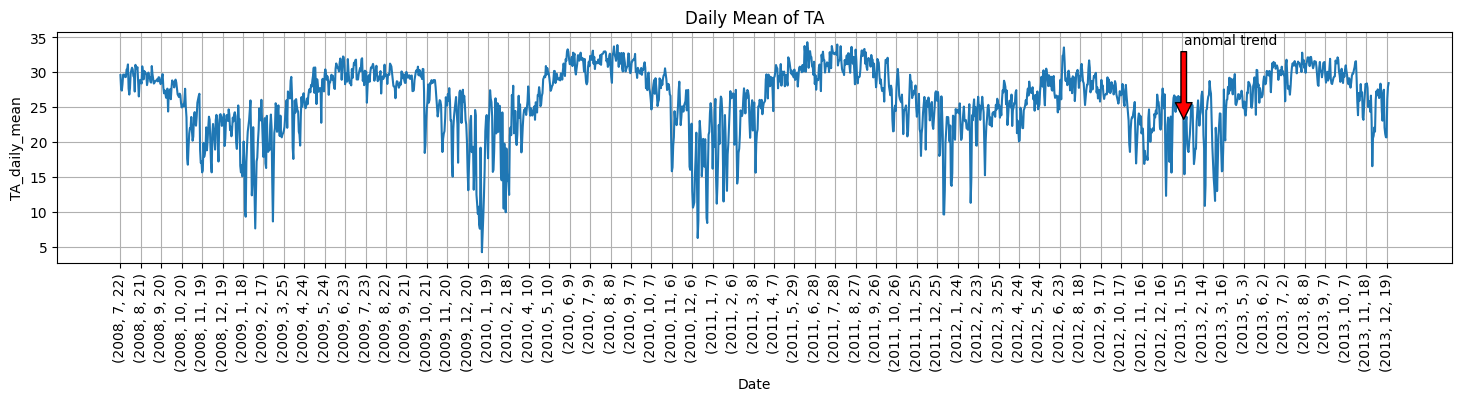

In [147]:
print('From this figure, we can easily identify the anomal trend around 2012-12 - 2013-01 ')

# Plot it as a figure

x_label = df_TA_YMD['Year_Month_Day'].tolist()[::30] # the label name
x_tick = np.arange(0, 1863,30)  # the label locations

y = df_TA_YMD['TA_daily_mean'].tolist()

fig, ax = plt.subplots(figsize = (18,3))
ax.plot(y)
ax.set_xticks(x_tick)
ax.set_xticklabels(labels=x_label,rotation = 90)
ax.set_xlabel('Date')  # Add an x-label to the axes.
ax.set_ylabel('TA_daily_mean')  # Add a y-label to the axes.

ax.annotate('anomal trend', xy=(1562,23.044444444444448),xytext = (1562,34),
            arrowprops=dict(facecolor='red', shrink=0.02))


ax.set_title("Daily Mean of TA")  # Add a title to the axes.
ax.grid(True)


plt.show()

In [148]:
df_TA_grouped_date.reset_index(level = ['Year','Month','Day'])

,Year,Month,Day,TA_daily_mean
0,2008,7,22,29.598235
1,2008,7,23,27.587200
2,2008,7,24,27.373600
3,2008,7,25,28.309333
4,2008,7,26,29.676130
...,...,...,...,...
1859,2013,12,18,20.690244
1860,2013,12,19,20.660865
1861,2013,12,20,26.153429
1862,2013,12,21,27.913810


In [149]:
# reshape the DataFrame
df_TA_YMD_new = df_TA_grouped_date.reset_index(level = ['Year','Month','Day']).pivot(index='Year', columns=['Month','Day'], values='TA_daily_mean')

print(df_TA_YMD_new.columns)

MultiIndex([(7, 22),
            (7, 23),
            (7, 24),
            (7, 25),
            (7, 26),
            (7, 27),
            (7, 28),
            (7, 29),
            (7, 30),
            (7, 31),
            ...
            (7, 18),
            (7, 19),
            (7, 20),
            (7, 21),
            (3, 11),
            (3,  3),
            (3,  8),
            (3, 14),
            (3, 15),
            (3, 17)],
           names=['Month', 'Day'], length=365)


### Anomal (outlier) detection by IQR

- Outlier detected by IQR
- we assume that TA should have a similar value for every month
- if the value beyond the 1.5*  IQR, we will think it as an outlier

In [ ]:
# In order to obtain the mean of TA_mean for each month, we need to drop the outliers

df_TA_YMD_new_good = df_TA_YMD_new.copy() # it store the data points not beyond the cap
count = 0 # count the number of outliers
for col in df_TA_YMD_new.columns:
   col_list = df_TA_YMD_new[col].tolist()
   x_25 = np.percentile(col_list,25)
   x_75 = np.percentile(col_list,75)
   IQR = x_75 - x_25
   whisker = IQR*1.5

   df_TA_YMD_new_good.loc[(df_TA_YMD_new_good[col] > x_75 + whisker) | (df_TA_YMD_new_good[col] < x_25 - whisker), col] = np.nan

   # to count the number of outliers
   for v in col_list:
    if v > x_75 + whisker or v < x_25 - whisker:
      count +=1

print('The number of outliers: ', count)

# drop the outliers
df_TA_YMD_new_good

The number of outliers:  45


Month         7                                                          \
Day           22         23         24         25         26         27   
Year                                                                      
2008   29.598235  27.587200        NaN  28.309333  29.676130  29.616800   
2009   30.228097  28.611765  30.102857  25.634211  27.928739  29.391852   
2010   31.604286  31.203815  32.472844  31.070677  32.586333  32.624839   
2011   30.594176  33.767893  33.179471  32.724273  32.740200  32.587161   
2012         NaN  32.371464  32.516091  33.568421  31.535552  28.840522   
2013   30.962024  31.342414  31.606944  30.908667  31.106383  29.855000   

Month                                                     8              \
Day           28         29         30         31         1          2    
Year                                                                      
2008   29.670750  29.303143  29.340000  30.399429  30.493158  31.133750   
2009   29.590588  28.639118  29.932414  30.700606  30.602333  30.934265   
2010   32.677818  32.965071  32.976067  33.008667        NaN  31.582767   
2011   32.808600  32.852941  32.542857  33.986957  30.978571  31.550000   
2012   28.738571  29.084167  28.153750  30.074000  30.236429        NaN   
2013   31.220875  31.540579  31.310861  31.334953  30.805891  30.785263   

Month                                                                    \
Day           3          4          5          6          7          8    
Year                                                                      
2008   27.650000  26.806364  27.736818  29.817368  30.303682  30.660032   
2009   31.210000  30.713263  28.788947  29.443571  30.122727  30.934871   
2010   31.906792  30.775333  31.084250  32.319600        NaN  30.788333   
2011   31.686733  31.828040  33.748148  31.640040  30.478571  30.087000   
2012   27.407125  27.974062  29.101500  27.006667        NaN  29.251163   
2013   30.058000  32.818619  31.250370  31.780045  30.643214  31.167333   

Month                                                                    \
Day           9          10         11         12         13         14   
Year                                                                      
2008   30.425897  29.450000  29.333214  27.238235  31.070074  30.594207   
2009   29.543737  28.730000  29.377778  28.960000  29.466316  30.172051   
2010   29.305625  28.486667  32.510324  32.834545  33.714481  32.515167   
2011   30.088926  29.606733  31.768227  31.123154  31.795238  32.433400   
2012   29.254146        NaN  27.520000  29.916875  29.994391  30.349091   
2013   29.930488  31.051687  31.516063  32.140407  32.130323  31.627027   

Month                                                                    \
Day           15         16         17         18         19         20   
Year                                                                      
2008   30.485385  30.737083  28.540455  26.536667  28.304667        NaN   
2009         NaN  28.993659  29.408604  29.026271  29.261775  31.094118   
2010   32.191818  31.650647  32.431783  33.909259  32.557563  30.781400   
2011   31.162625  32.736364  32.712562  30.925042  29.936409  31.975897   
2012   29.418667  27.764375  29.399091  28.752800  30.781724  31.203200   
2013   30.886800  32.191081  32.210564  31.538979  31.095333  30.580545   

Month                                                                    \
Day           21         22         23         24         25         26   
Year                                                                      
2008   28.783721  28.384516  30.856364  29.993000  28.986842  30.200115   
2009   29.435344  29.543478  29.702273  28.332353  29.583897  29.721220   
2010   32.754333  31.225500  31.661625  32.774375  30.546538  30.121351   
2011   33.650077  31.820000  31.230000  32.202971  30.228911  28.284615   
2012   29.911821  28.718657  28.450244  26.760952        NaN  26.513478   
2013   30.957894  31

In [ ]:
df_TA_YMD_new_good # check

Month         7                                                          \
Day           22         23         24         25         26         27   
Year                                                                      
2008   29.598235  27.587200        NaN  28.309333  29.676130  29.616800   
2009   30.228097  28.611765  30.102857  25.634211  27.928739  29.391852   
2010   31.604286  31.203815  32.472844  31.070677  32.586333  32.624839   
2011   30.594176  33.767893  33.179471  32.724273  32.740200  32.587161   
2012         NaN  32.371464  32.516091  33.568421  31.535552  28.840522   
2013   30.962024  31.342414  31.606944  30.908667  31.106383  29.855000   

Month                                                     8              \
Day           28         29         30         31         1          2    
Year                                                                      
2008   29.670750  29.303143  29.340000  30.399429  30.493158  31.133750   
2009   29.590588  28.639118  29.932414  30.700606  30.602333  30.934265   
2010   32.677818  32.965071  32.976067  33.008667        NaN  31.582767   
2011   32.808600  32.852941  32.542857  33.986957  30.978571  31.550000   
2012   28.738571  29.084167  28.153750  30.074000  30.236429        NaN   
2013   31.220875  31.540579  31.310861  31.334953  30.805891  30.785263   

Month                                                                    \
Day           3          4          5          6          7          8    
Year                                                                      
2008   27.650000  26.806364  27.736818  29.817368  30.303682  30.660032   
2009   31.210000  30.713263  28.788947  29.443571  30.122727  30.934871   
2010   31.906792  30.775333  31.084250  32.319600        NaN  30.788333   
2011   31.686733  31.828040  33.748148  31.640040  30.478571  30.087000   
2012   27.407125  27.974062  29.101500  27.006667        NaN  29.251163   
2013   30.058000  32.818619  31.250370  31.780045  30.643214  31.167333   

Month                                                                    \
Day           9          10         11         12         13         14   
Year                                                                      
2008   30.425897  29.450000  29.333214  27.238235  31.070074  30.594207   
2009   29.543737  28.730000  29.377778  28.960000  29.466316  30.172051   
2010   29.305625  28.486667  32.510324  32.834545  33.714481  32.515167   
2011   30.088926  29.606733  31.768227  31.123154  31.795238  32.433400   
2012   29.254146        NaN  27.520000  29.916875  29.994391  30.349091   
2013   29.930488  31.051687  31.516063  32.140407  32.130323  31.627027   

Month                                                                    \
Day           15         16         17         18         19         20   
Year                                                                      
2008   30.485385  30.737083  28.540455  26.536667  28.304667        NaN   
2009         NaN  28.993659  29.408604  29.026271  29.261775  31.094118   
2010   32.191818  31.650647  32.431783  33.909259  32.557563  30.781400   
2011   31.162625  32.736364  32.712562  30.925042  29.936409  31.975897   
2012   29.418667  27.764375  29.399091  28.752800  30.781724  31.203200   
2013   30.886800  32.191081  32.210564  31.538979  31.095333  30.580545   

Month                                                                    \
Day           21         22         23         24         25         26   
Year                                                                      
2008   28.783721  28.384516  30.856364  29.993000  28.986842  30.200115   
2009   29.435344  29.543478  29.702273  28.332353  29.583897  29.721220   
2010   32.754333  31.225500  31.661625  32.774375  30.546538  30.121351   
2011   33.650077  31.820000  31.230000  32.202971  30.228911  28.284615   
2012   29.911821  28.718657  28.450244  26.760952        NaN  26.513478   
2013   30.957894  31

#### Monthly Mean of TA

In [ ]:
# calculate the monthly mean of TA based on df_TA_YMD_new_good

df_TA_TMD_mean_std = df_TA_YMD_new_good.transpose().groupby(['Month']).mean().transpose().describe().loc[['mean','std']]
df_TA_TMD_mean_std # This mean of TA get from the daily outlier detection

Month,1,2,3,4,5,6,7,8,9,10,11,12
mean,20.425349,21.576968,22.267015,26.091441,28.186787,30.029237,30.319991,30.335366,29.50191,27.512294,23.725643,22.215150
std,2.258817,2.286010,2.580556,1.842323,1.393180,1.476797,0.923276,1.090087,1.22059,1.309902,1.715748,2.610509


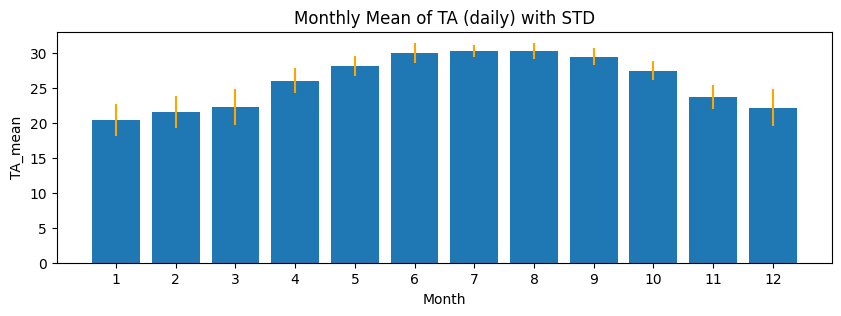

In [ ]:
# barplot with std

fig, ax = plt.subplots(figsize = (10,3))

ax.bar(df_TA_TMD_mean_std.columns, df_TA_TMD_mean_std.loc['mean'],
       yerr=df_TA_TMD_mean_std.loc['std'], ecolor = 'orange')
ax.set_xticks(df_TA_TMD_mean_std.columns)
ax.set_xlabel('Month')
ax.set_ylabel('TA_mean')
ax.set_title('Monthly Mean of TA (daily) with STD')

plt.show()


## By Year-Month

In [ ]:
# Groupby 'Year','Month'
df_TA_grouped = df_TA.groupby([df_TA['TIMESTAMP_START'].dt.year,
                               df_TA['TIMESTAMP_START'].dt.month])['TA'].mean().to_frame() # convert groupby object to DataFrame


# Rename the index, column
df_TA_grouped.index=df_TA_grouped.index.rename(['Year','Month'])
df_TA_grouped.columns = ['TA_mean']

In [ ]:
# TA_mean by Year_Month
df_TA_grouped.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 66 entries, (2008, 7) to (2013, 12)
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   TA_mean  66 non-null     float64
dtypes: float64(1)
memory usage: 911.0 bytes


In [ ]:
# reset index, combine the multiple index in to one index as [Year,Month]

# Flatten the index to columns as level = ['Year','Month'])
df_TA_YM  = df_TA_grouped.reset_index(level = ['Year','Month'])

# Create a new colums, then set it as a new index
df_TA_YM['Year_Month'] = [tuple(y_m) for y_m in df_TA_YM[['Year','Month']].values.tolist()]

# Drop the column Year, column Month
df_TA_YM.drop(columns = ['Year', 'Month'], inplace = True)

# df_TA_YM as new DataFrame with Year_Month as index, TA_mean as Value
df_TA_YM

,TA_mean,Year_Month
0,29.038661,"(2008, 7)"
1,29.303876,"(2008, 8)"
2,28.565041,"(2008, 9)"
3,25.639264,"(2008, 10)"
4,21.270129,"(2008, 11)"
...,...,...
61,31.027883,"(2013, 8)"
62,30.054555,"(2013, 9)"
63,29.196043,"(2013, 10)"
64,24.809356,"(2013, 11)"


<ipython-input-80-1f38f489bf05>:15: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  ax.annotate('anomal trend', xy=(54,23.32263829787234), textcoords='offset points',


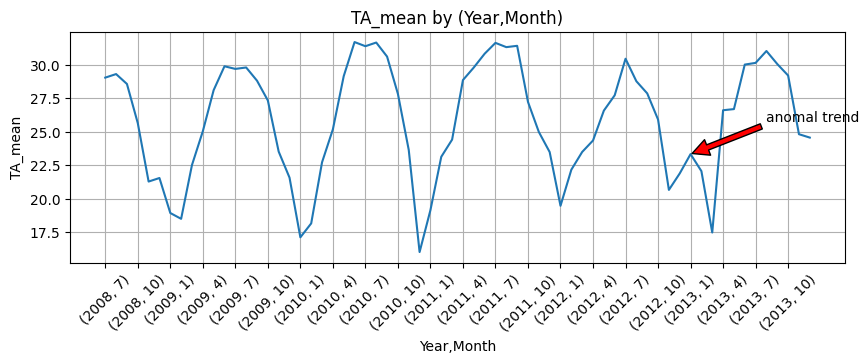

In [ ]:
# Plot it as a figure

x_label = df_TA_YM['Year_Month'].tolist()[::3] # the label name
x_tick = np.arange(0, 66,3)  # the label locations

y = df_TA_YM['TA_mean'].tolist()

fig, ax = plt.subplots(figsize = (10,3))
ax.plot(y)
ax.set_xticks(x_tick)
ax.set_xticklabels(labels=x_label,rotation = 45)
ax.set_xlabel('Year,Month')  # Add an x-label to the axes.
ax.set_ylabel('TA_mean')  # Add a y-label to the axes.

ax.annotate('anomal trend', xy=(54,23.32263829787234), textcoords='offset points',
            arrowprops=dict(facecolor='red', shrink=0.02))


ax.set_title("TA_mean by (Year,Month)")  # Add a title to the axes.
ax.grid(True)


plt.show()

### Anomal detection by IQR

- Before get the mean of each month, find and remove the outliers
- Uss BoxPlot to detect the outliers

In [ ]:
df_TA_M = df_TA_grouped.reset_index(level = ['Year','Month'])
df_TA_M

,Year,Month,TA_mean
0,2008,7,29.038661
1,2008,8,29.303876
2,2008,9,28.565041
3,2008,10,25.639264
4,2008,11,21.270129
...,...,...,...
61,2013,8,31.027883
62,2013,9,30.054555
63,2013,10,29.196043
64,2013,11,24.809356


In [ ]:
# reshape the DataFrame
df_TA_M_new = df_TA_M.pivot(index='Year', columns='Month', values='TA_mean')

df_TA_M_new

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2008,NaN,NaN,NaN,NaN,NaN,NaN,29.038661,29.303876,28.565041,25.639264,21.270129,21.534982
2009,18.919827,18.483158,22.505198,25.025023,28.100893,29.887075,29.690121,29.796792,28.809861,27.332099,23.509824,21.563125
2010,17.102047,18.142874,22.708305,25.173094,29.147258,31.696932,31.386613,31.661251,30.611179,27.820932,23.632527,16.000535
2011,19.133036,23.120641,24.405673,28.857697,29.794622,30.824013,31.635686,31.317011,31.415896,27.221818,24.980287,23.476666
2012,19.457702,22.156040,23.482781,24.340162,26.572125,27.717985,30.450106,28.767603,27.861383,25.906240,20.646604,21.876358
2013,23.322638,22.048092,17.462095,26.601247,26.685817,30.013004,30.139763,31.027883,30.054555,29.196043,24.809356,24.555719


In [ ]:
df_TA_M_new.describe()

Month,1,2,3,4,5,6,7,8,9,10,11,12
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,19.587050,20.790161,22.112810,25.999445,28.060143,30.027802,30.390158,30.312403,29.552986,27.186066,23.141454,21.501231
std,2.280236,2.302691,2.705170,1.797035,1.440040,1.481150,0.992688,1.184055,1.358791,1.303550,1.803673,2.954170
min,17.102047,18.142874,17.462095,24.340162,26.572125,27.717985,29.038661,28.767603,27.861383,25.639264,20.646604,16.000535
25%,18.919827,18.483158,22.505198,25.025023,26.685817,29.887075,29.802531,29.427105,28.626246,26.235134,21.830053,21.542017
50%,19.133036,22.048092,22.708305,25.173094,28.100893,30.013004,30.294935,30.412338,29.432208,27.276958,23.571175,21.719741
75%,19.457702,22.156040,23.482781,26.601247,29.147258,30.824013,31.152486,31.244729,30.472023,27.698724,24.515149,23.076589
max,23.322638,23.120641,24.405673,28.857697,29.794622,31.696932,31.635686,31.661251,31.415896,29.196043,24.980287,24.555719


From the violin plot, we can see the distribution of TA_mean for each month
From the boxplot, we can identify the filter points(outliers) of TA_mean for each month


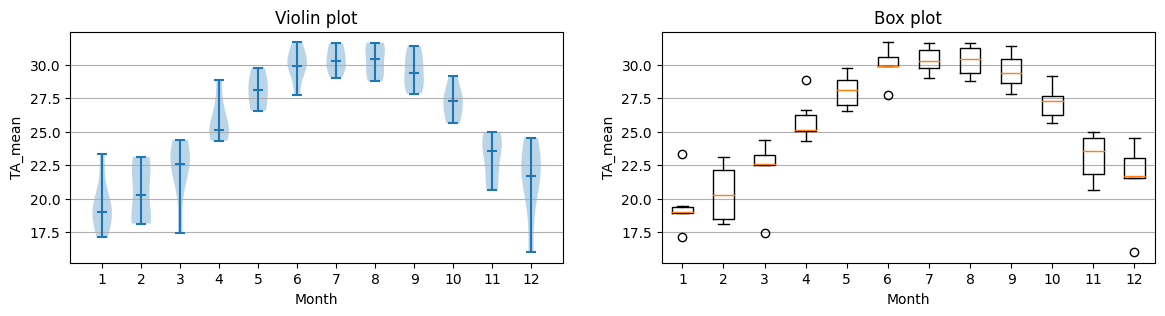

In [ ]:
# Boxplot: show boxplot(Q1,Q2,Q3) and filer points(beyond the whis*(IQR = Q3-Q1))
# Violin Plot: show the distribution of data

print('From the violin plot, we can see the distribution of TA_mean for each month')
print('From the boxplot, we can identify the filter points(outliers) of TA_mean for each month')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 3))

data = df_TA_M_new.fillna(method="bfill") # fill the gap in year 2008 from month 1 to 6; in order to draw boxplot

# plot violin plot
axs[0].violinplot(data,
                  showmeans=False,
                  showmedians=True)
axs[0].set_title('Violin plot')

# plot box plot
axs[1].boxplot(data, whis=1.5, showcaps = True) # set the whist as 2.5, if the value beyond the 1.5*IQR, it will be pointed as filter point
axs[1].set_title('Box plot')

# adding horizontal grid lines
for ax in axs:
    ax.yaxis.grid(True)
    ax.set_xticks([y+1 for y in range(len(data.columns))],
                  labels=[col for col in data.columns])
    ax.set_xlabel('Month')
    ax.set_ylabel('TA_mean')

plt.show()

In [ ]:
# In order to obtain the mean of TA_mean for each month, we need to drop the outliers
df_TA_M_new_good = data.copy() # it store the data points not beyond the cap
for col in data.columns:
   col_list = data[col].tolist()
   x_25 = np.percentile(col_list,25)
   x_75 = np.percentile(col_list,75)
   IQR = x_75 - x_25
   whisker = IQR*1.5
   df_TA_M_new_good.loc[(df_TA_M_new_good[col] > x_75 + whisker) | (df_TA_M_new_good[col] < x_25 - whisker), col] = np.nan

# drop the outliers
df_TA_M_new_good

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2008,18.919827,18.483158,22.505198,25.025023,28.100893,29.887075,29.038661,29.303876,28.565041,25.639264,21.270129,21.534982
2009,18.919827,18.483158,22.505198,25.025023,28.100893,29.887075,29.690121,29.796792,28.809861,27.332099,23.509824,21.563125
2010,NaN,18.142874,22.708305,25.173094,29.147258,31.696932,31.386613,31.661251,30.611179,27.820932,23.632527,NaN
2011,19.133036,23.120641,24.405673,NaN,29.794622,30.824013,31.635686,31.317011,31.415896,27.221818,24.980287,23.476666
2012,19.457702,22.156040,23.482781,24.340162,26.572125,NaN,30.450106,28.767603,27.861383,25.906240,20.646604,21.876358
2013,NaN,22.048092,NaN,26.601247,26.685817,30.013004,30.139763,31.027883,30.054555,29.196043,24.809356,24.555719


In [ ]:
df_TA_M_new_good.describe()

Month,1,2,3,4,5,6,7,8,9,10,11,12
count,4.000000,6.000000,5.000000,5.000000,6.000000,5.000000,6.000000,6.000000,6.000000,6.000000,6.000000,5.000000
mean,19.107598,20.405661,23.121431,25.232910,28.066935,30.461620,30.390158,30.312403,29.552986,27.186066,23.141454,22.601370
std,0.254123,2.264719,0.823106,0.830566,1.288118,0.793534,0.992688,1.184055,1.358791,1.303550,1.803673,1.353367
min,18.919827,18.142874,22.505198,24.340162,26.572125,29.887075,29.038661,28.767603,27.861383,25.639264,20.646604,21.534982
25%,18.919827,18.483158,22.505198,25.025023,27.039586,29.887075,29.802531,29.427105,28.626246,26.235134,21.830053,21.563125
50%,19.026432,20.265625,22.708305,25.025023,28.100893,30.013004,30.294935,30.412338,29.432208,27.276958,23.571175,21.876358
75%,19.214203,22.129053,23.482781,25.173094,28.885667,30.824013,31.152486,31.244729,30.472023,27.698724,24.515149,23.476666
max,19.457702,23.120641,24.405673,26.601247,29.794622,31.696932,31.635686,31.661251,31.415896,29.196043,24.980287,24.555719


In [ ]:
df_TA_M_mean_std = df_TA_M_new_good.describe().loc[['mean','std']]

df_TA_M_mean_std # This mean of TA get from the monthly outlier detection

Month,1,2,3,4,5,6,7,8,9,10,11,12
mean,19.107598,20.405661,23.121431,25.232910,28.066935,30.461620,30.390158,30.312403,29.552986,27.186066,23.141454,22.601370
std,0.254123,2.264719,0.823106,0.830566,1.288118,0.793534,0.992688,1.184055,1.358791,1.303550,1.803673,1.353367


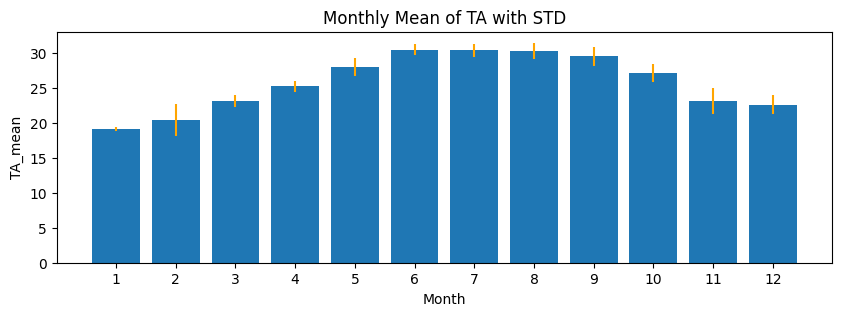

In [ ]:
# barplot with std

fig, ax = plt.subplots(figsize = (10,3))

ax.bar(df_TA_M_mean_std.columns, df_TA_M_mean_std.loc['mean'],
       yerr=df_TA_M_mean_std.loc['std'], ecolor = 'orange')
ax.set_xticks(df_TA_M_mean_std.columns)
ax.set_xlabel('Month')
ax.set_ylabel('TA_mean')
ax.set_title('Monthly Mean of TA with STD')

plt.show()

## Compared two "Monthly Mean of TA" based on outlier detection at different levels (Monthly, Daily)

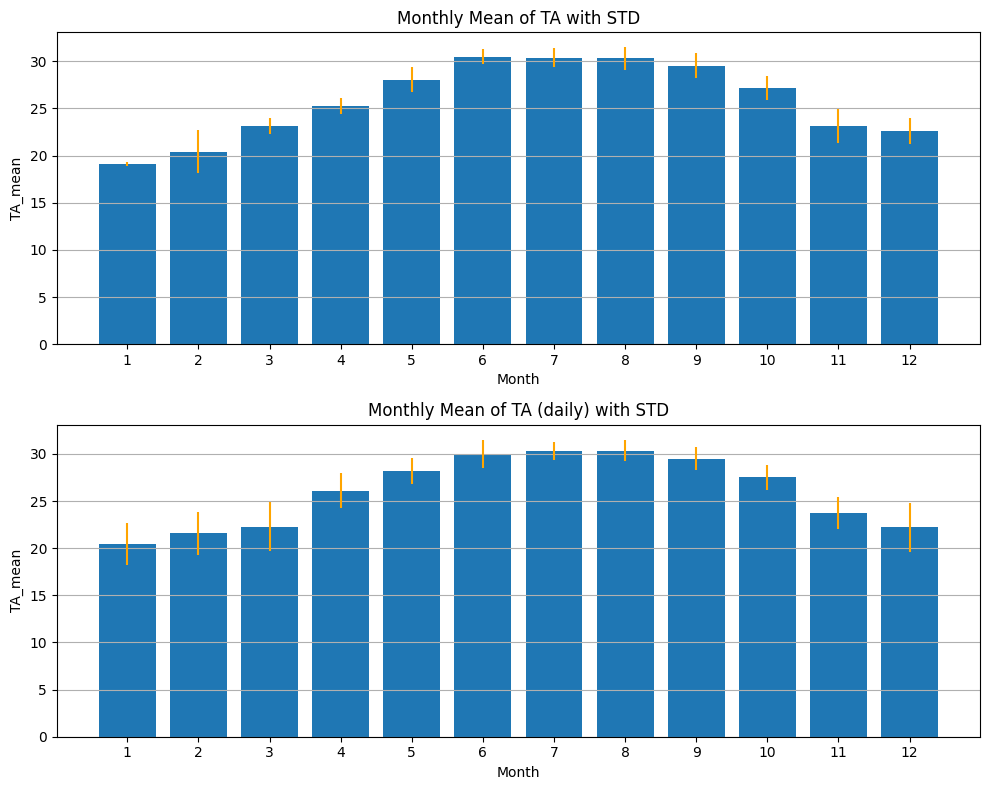

In [ ]:
fig, axes = plt.subplots(2,1,figsize = (10,8))

axes[0].bar(df_TA_M_mean_std.columns, df_TA_M_mean_std.loc['mean'],
       yerr=df_TA_M_mean_std.loc['std'], ecolor = 'orange')
axes[0].set_xticks(df_TA_M_mean_std.columns)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('TA_mean')
axes[0].set_title('Monthly Mean of TA with STD')
axes[0].yaxis.grid(True)

axes[1].bar(df_TA_TMD_mean_std.columns, df_TA_TMD_mean_std.loc['mean'],
       yerr=df_TA_TMD_mean_std.loc['std'], ecolor = 'orange')
axes[1].set_xticks(df_TA_TMD_mean_std.columns)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('TA_mean')
axes[1].set_title('Monthly Mean of TA (daily) with STD')
axes[1].yaxis.grid(True)

fig.tight_layout()
plt.show()

## Aggregate TA monthly mean into two seasons
- Dry: March - August
- Wet: September - February

In [ ]:
df_TA_M_mean_std

Month,1,2,3,4,5,6,7,8,9,10,11,12
mean,19.107598,20.405661,23.121431,25.232910,28.066935,30.461620,30.390158,30.312403,29.552986,27.186066,23.141454,22.601370
std,0.254123,2.264719,0.823106,0.830566,1.288118,0.793534,0.992688,1.184055,1.358791,1.303550,1.803673,1.353367


In [ ]:
df_TA_M_mean_std_wet = df_TA_M_mean_std[[3,4,5,6,7,8]]
df_TA_M_mean_std_dry = df_TA_M_mean_std[[9,10,11,12,1,2]]

df_TA_M_mean_std_dry

Month,9,10,11,12,1,2
mean,29.552986,27.186066,23.141454,22.601370,19.107598,20.405661
std,1.358791,1.303550,1.803673,1.353367,0.254123,2.264719


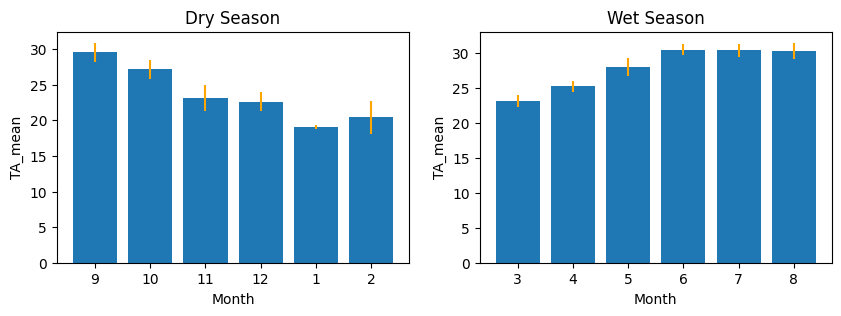

In [ ]:
# barplot with std

fig, axes = plt.subplots(1,2,figsize = (10,3))

dry_m = [str(x) for x in df_TA_M_mean_std_dry.columns]
dry_m_TA = list(df_TA_M_mean_std_dry.loc['mean'])
dry_m_std =list(df_TA_M_mean_std_dry.loc['std'])
x_tick = np.arange(0,len(dry_m))  # the label locations

axes[0].bar(dry_m, dry_m_TA,
            yerr=dry_m_std,
            ecolor = 'orange')
axes[0].set_xticks(x_tick, labels = dry_m)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('TA_mean')
axes[0].set_title('Dry Season')


axes[1].bar(df_TA_M_mean_std_wet.columns, df_TA_M_mean_std_wet.loc['mean'],
       yerr=df_TA_M_mean_std_wet.loc['std'], ecolor = 'orange')
axes[1].set_xticks(df_TA_M_mean_std_wet.columns)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('TA_mean')
axes[1].set_title('Wet Season')


plt.show()

## Quarterly mean of TA

In [ ]:
df_TA_M_new_good # TA_mean without outliers

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2008,18.919827,18.483158,22.505198,25.025023,28.100893,29.887075,29.038661,29.303876,28.565041,25.639264,21.270129,21.534982
2009,18.919827,18.483158,22.505198,25.025023,28.100893,29.887075,29.690121,29.796792,28.809861,27.332099,23.509824,21.563125
2010,NaN,18.142874,22.708305,25.173094,29.147258,31.696932,31.386613,31.661251,30.611179,27.820932,23.632527,NaN
2011,19.133036,23.120641,24.405673,NaN,29.794622,30.824013,31.635686,31.317011,31.415896,27.221818,24.980287,23.476666
2012,19.457702,22.156040,23.482781,24.340162,26.572125,NaN,30.450106,28.767603,27.861383,25.906240,20.646604,21.876358
2013,NaN,22.048092,NaN,26.601247,26.685817,30.013004,30.139763,31.027883,30.054555,29.196043,24.809356,24.555719


In [ ]:
df_TA_S = df_TA_M_new_good.transpose().unstack().to_frame().reset_index(level = ['Year','Month'])

df_TA_S['Year_Month'] = [datetime.datetime(y, m, 1) for y, m in zip(df_TA_S['Year'],df_TA_S['Month'])]
df_TA_S.drop(columns = ['Year', 'Month'], inplace = True)

# Set 'column_name' as the index
df_TA_S.set_index('Year_Month', inplace=True)

df_TA_S.rename(columns = {0:'TA_mean'},inplace = True)
df_TA_S

,TA_mean
Year_Month,
2008-01-01,18.919827
2008-02-01,18.483158
2008-03-01,22.505198
2008-04-01,25.025023
2008-05-01,28.100893
...,...
2013-08-01,31.027883
2013-09-01,30.054555
2013-10-01,29.196043


In [ ]:
df_TA_S_mean = pd.DataFrame()
df_TA_S_mean['TA_S_mean'] = df_TA_S.resample('Q')['TA_mean'].mean()
df_TA_S_mean['TA_S_std'] = df_TA_S.resample('Q')['TA_mean'].std()

df_TA_S_mean

,TA_S_mean,TA_S_std
Year_Month,,
2008-03-31,19.969394,2.206897
2008-06-30,27.670997,2.459369
2008-09-30,28.969193,0.374284
2008-12-31,22.814792,2.449647
2009-03-31,19.969394,2.206897
2009-06-30,27.670997,2.459369
2009-09-30,29.432258,0.541644
2009-12-31,24.135016,2.934862
2010-03-31,20.425589,3.228247


In [ ]:
df_TA_S_mean =  df_TA_S_mean.reset_index()
df_TA_S_mean

,Year_Month,TA_S_mean,TA_S_std
0,2008-03-31,19.969394,2.206897
1,2008-06-30,27.670997,2.459369
2,2008-09-30,28.969193,0.374284
3,2008-12-31,22.814792,2.449647
4,2009-03-31,19.969394,2.206897
5,2009-06-30,27.670997,2.459369
6,2009-09-30,29.432258,0.541644
7,2009-12-31,24.135016,2.934862
8,2010-03-31,20.425589,3.228247
9,2010-06-30,28.672428,3.287737


<ipython-input-179-a80c91f9304e>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation = 75)


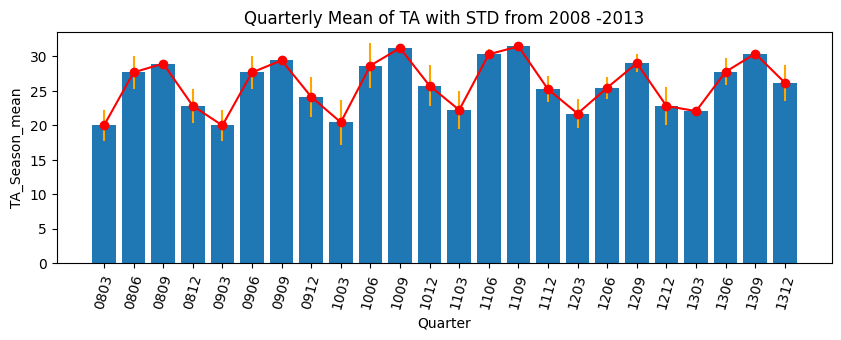

In [ ]:
# barplot with std
fig, ax = plt.subplots(figsize = (10,3))
x = [x.strftime('%y%m') for x in df_TA_S_mean['Year_Month']]
y = df_TA_S_mean['TA_S_mean']
ax.bar(x,y,
       yerr=df_TA_S_mean['TA_S_std'],
       ecolor = 'orange')
ax.plot(x, y,'ro-',linewidth = 1.5)

ax.set_xticklabels(x, rotation = 75)
ax.set_xlabel('Quarter')
ax.set_ylabel('TA_Season_mean')
ax.set_title('Quarterly Mean of TA with STD from 2008 -2013')

plt.show()

# CO2 Flux

In [19]:
df_FC = df[['TIMESTAMP_START','FC']]

In [20]:
df_FC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54610 entries, 0 to 54609
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   TIMESTAMP_START  54610 non-null  datetime64[ns]
 1   FC               54610 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 853.4 KB


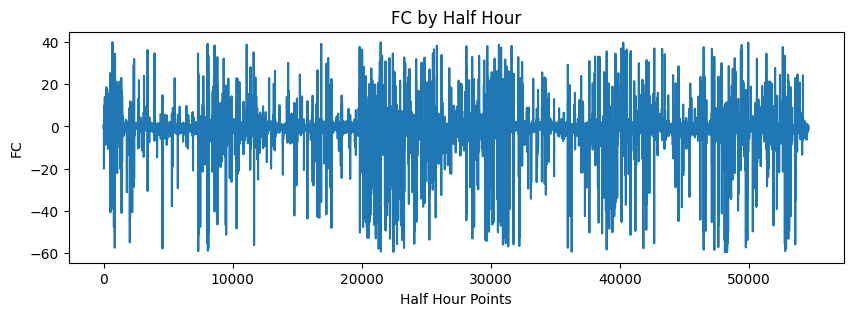

In [21]:
# Plot it as a figure
y = df_FC['FC'].tolist()

fig, ax = plt.subplots(figsize = (10,3))
ax.plot(y)
#ax.set_xticks(x_tick)
#ax.set_xticklabels(labels=x_label,rotation = 45)
ax.set_xlabel('Half Hour Points')  # Add an x-label to the axes.
ax.set_ylabel('FC')  # Add a y-label to the axes.

"""ax.annotate('anomal trend', xy=(54,23.32263829787234), textcoords='offset points',
            arrowprops=dict(facecolor='red', shrink=0.02))
"""
ax.set_title("FC by Half Hour")  # Add a title to the axes.
ax.grid(False)


plt.show()

From the histogram plot, we can see the distribution of FC
From the boxplot, we can identify the filter points(outliers) of FC by IQR


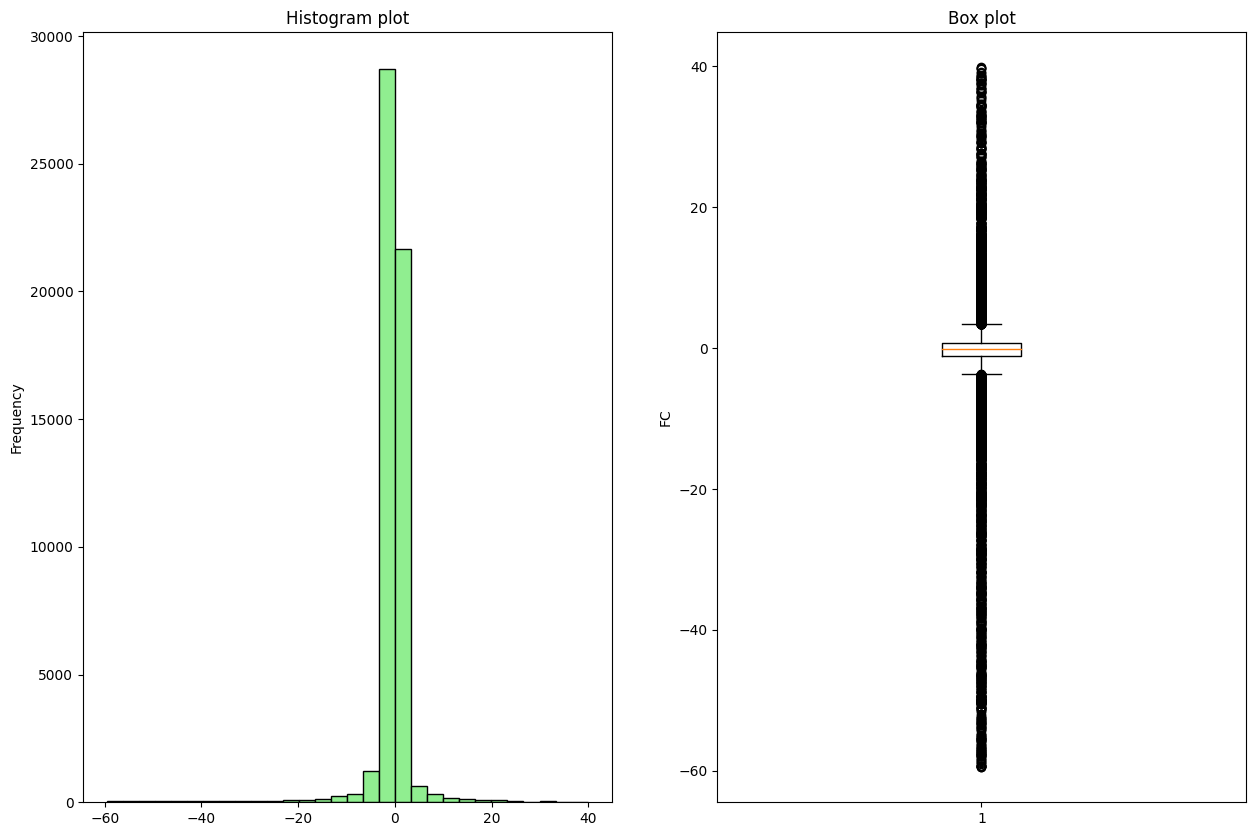

In [118]:
# Boxplot: show boxplot(Q1,Q2,Q3) and filer points(beyond the whis*(IQR = Q3-Q1))
# Histogram Plot: show the distribution of data

print('From the histogram plot, we can see the distribution of FC')
print('From the boxplot, we can identify the filter points(outliers) of FC by IQR')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

data = df_FC['FC'].tolist()

#create histogram to show the distribution of FC, the y_axis is the frequency of those data
axs[0].hist(data, bins = 30, color='lightgreen', ec='black')
axs[0].set_ylabel('Frequency')  # Add a y-label to the axes.
axs[0].set_title('Histogram plot')

# create a boxplot
axs[1].boxplot(data, whis=1.5, showcaps = True) # set the whist as 2.5, if the value beyond the 1.5*IQR, it will be pointed as filter point
axs[1].set_ylabel('FC')  # Add a y-label to the axes.
axs[1].set_title('Box plot')


plt.show()

## by Year-Month-Day

In [23]:
# Groupby Day
df_FC_grouped_date = df_FC.groupby([df_FC['TIMESTAMP_START'].dt.year,
                                    df_FC['TIMESTAMP_START'].dt.month,
                                    df_FC['TIMESTAMP_START'].dt.day])['FC'].mean().to_frame() # convert groupby object to DataFrame
# Rename the index, column
df_FC_grouped_date.index=df_FC_grouped_date.index.rename(['Year','Month','Day'])
df_FC_grouped_date.columns = ['FC_daily_mean']

df_FC_grouped_date

FC_daily_mean
Year Month Day               
2008 7     22       -1.477412
           23        0.182200
           24        0.056240
           25       -0.903600
           26        0.043000
...                       ...
2013 12    18       -0.700537
           19       -0.484568
           20       -0.393629
           21       -1.134333
           22       -1.396588

[1864 rows x 1 columns]

In [24]:
# reset index, combine the multiple index in to one index as [Year,Month]

# Flatten the index to columns as level = ['Year','Month'.'Day'])
df_FC_YMD  = df_FC_grouped_date.reset_index(level = ['Year','Month','Day'])

# Create a new colums, then set it as a new index
df_FC_YMD['Year_Month_Day'] = [tuple(y_m_d) for y_m_d in df_FC_YMD[['Year','Month','Day']].values.tolist()]

# Drop the column Year, column Month
df_FC_YMD.drop(columns = ['Year','Month','Day'], inplace = True)

# df_TA_YMD as new DataFrame with Year_Month_Day as index, FC_mean as Value
df_FC_YMD

,FC_daily_mean,Year_Month_Day
0,-1.477412,"(2008, 7, 22)"
1,0.182200,"(2008, 7, 23)"
2,0.056240,"(2008, 7, 24)"
3,-0.903600,"(2008, 7, 25)"
4,0.043000,"(2008, 7, 26)"
...,...,...
1859,-0.700537,"(2013, 12, 18)"
1860,-0.484568,"(2013, 12, 19)"
1861,-0.393629,"(2013, 12, 20)"
1862,-1.134333,"(2013, 12, 21)"


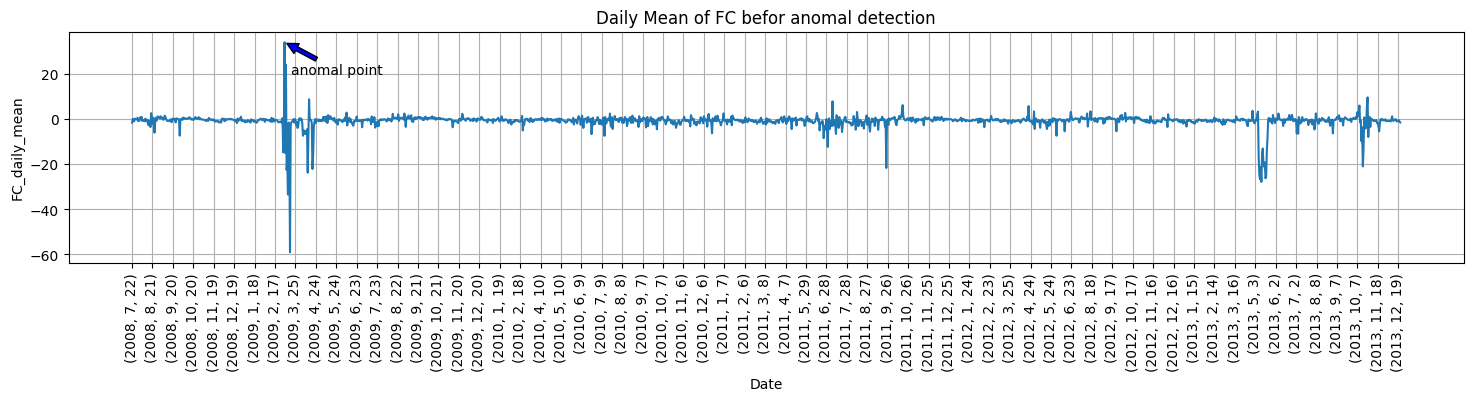

In [25]:
# Plot it as a figure
x_label = df_FC_YMD['Year_Month_Day'].tolist()[::30] # the label name
x_tick = np.arange(0, 1863,30)  # the label locations

y = df_FC_YMD['FC_daily_mean'].tolist()

fig, ax = plt.subplots(figsize = (18,3))
ax.plot(y)
ax.set_xticks(x_tick)
ax.set_xticklabels(labels=x_label,rotation = 90)
ax.set_xlabel('Date')  # Add an x-label to the axes.
ax.set_ylabel('FC_daily_mean')  # Add a y-label to the axes.

ax.annotate('anomal point', xy=(224,34.209),xytext = (234,20),
            arrowprops = dict(
                          arrowstyle='simple,tail_width=0.3,head_width=0.8,head_length=0.8',
                          facecolor='b', shrinkB=1.5 * 1.2))

ax.set_title("Daily Mean of FC befor anomal detection")  # Add a title to the axes.
ax.grid(True)


plt.show()

From the histogram plot, we can see the distribution of FC
From the boxplot, we can identify the filter points(outliers) of FC by IQR


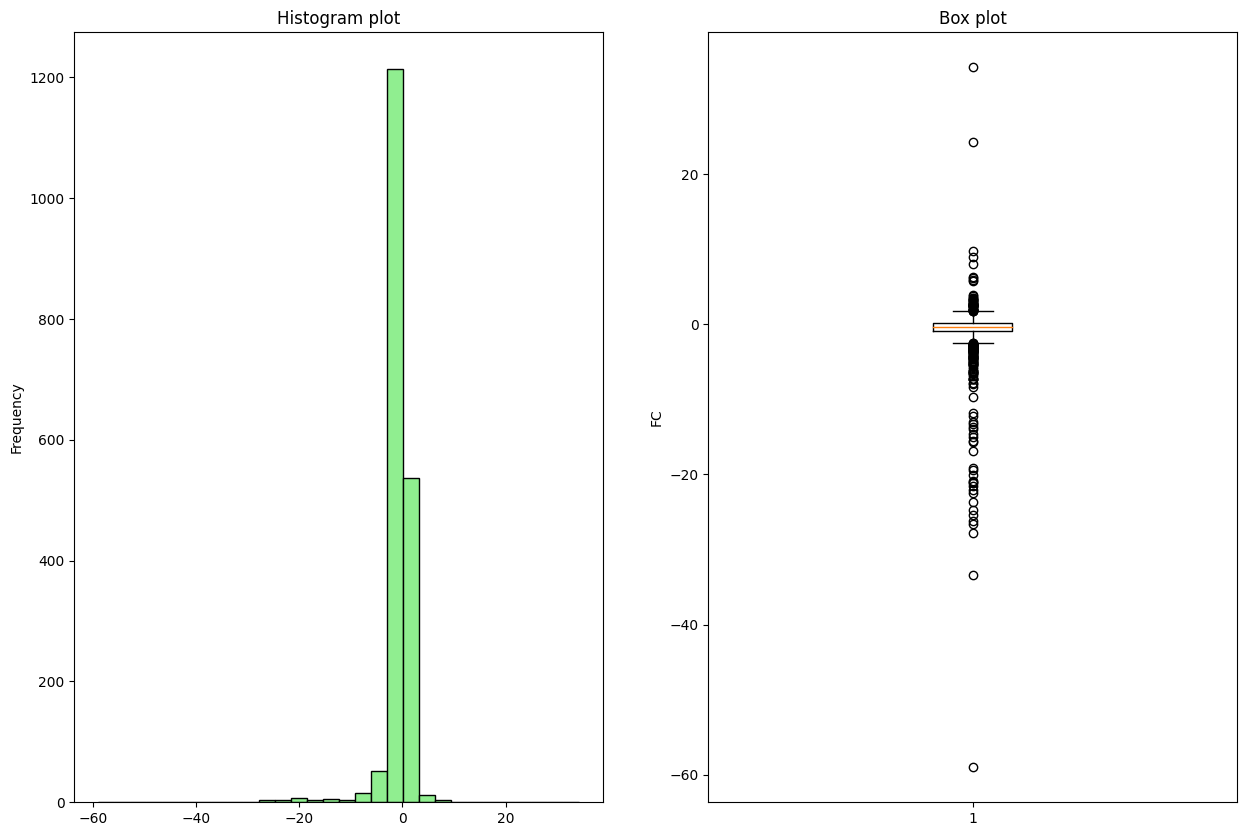

In [119]:
# Boxplot: show boxplot(Q1,Q2,Q3) and filer points(beyond the whis*(IQR = Q3-Q1))
# Histogram Plot: show the distribution of data

print('From the histogram plot, we can see the distribution of FC')
print('From the boxplot, we can identify the filter points(outliers) of FC by IQR')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))


data = df_FC_YMD['FC_daily_mean'].tolist()

#create histogram to show the distribution of FC, the y_axis is the frequency of those data
axs[0].hist(data, bins = 30, color='lightgreen', ec='black')
axs[0].set_ylabel('Frequency')  # Add a y-label to the axes.
axs[0].set_title('Histogram plot')

# create a boxplot
axs[1].boxplot(data, whis=1.5, showcaps = True) # set the whist as 2.5, if the value beyond the 1.5*IQR, it will be pointed as filter point
axs[1].set_ylabel('FC')  # Add a y-label to the axes.
axs[1].set_title('Box plot')


plt.show()

### Outlier detection based on Z-score or IQR
- We detect outliers on level of **daily mean**
  - FC_mean should be normally distributed cross the entire time
  - IQR is robust to outliers

In [26]:
df_FC_grouped_date

FC_daily_mean
Year Month Day               
2008 7     22       -1.477412
           23        0.182200
           24        0.056240
           25       -0.903600
           26        0.043000
...                       ...
2013 12    18       -0.700537
           19       -0.484568
           20       -0.393629
           21       -1.134333
           22       -1.396588

[1864 rows x 1 columns]

#### IQR

In [111]:
df_FC_YMD_IQR_good = df_FC_grouped_date.copy() # it store the data points not beyond the cap
count = 0 # count the number of outliers

x_25 = np.percentile(df_FC_YMD_IQR_good['FC_daily_mean'],25)
x_75 = np.percentile(df_FC_YMD_IQR_good['FC_daily_mean'],75)
IQR = x_75 - x_25
whisker = IQR*1.5

df_FC_YMD_IQR_good.loc[(df_FC_YMD_IQR_good['FC_daily_mean'] > x_75 + whisker) | (df_FC_YMD_IQR_good['FC_daily_mean'] < x_25 - whisker), 'FC_daily_mean'] = np.nan

# to count the number of outliers
for v in df_FC_grouped_date['FC_daily_mean']:
    if v > x_75 + whisker or v < x_25 - whisker:
      count +=1

print('The number of outliers: ', count)
print('IQR outlier: ',[x_25 - whisker, x_75 + whisker])
# drop the outliers
df_FC_YMD_IQR_good

The number of outliers:  174
IQR outlier:  [-2.524416787883632, 1.7672657249040922]


FC_daily_mean
Year Month Day               
2008 7     22       -1.477412
           23        0.182200
           24        0.056240
           25       -0.903600
           26        0.043000
...                       ...
2013 12    18       -0.700537
           19       -0.484568
           20       -0.393629
           21       -1.134333
           22       -1.396588

[1864 rows x 1 columns]

In [28]:
df_FC_YMD_IQR_good.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1864 entries, (2008, 7, 22) to (2013, 12, 22)
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FC_daily_mean  1690 non-null   float64
dtypes: float64(1)
memory usage: 20.6 KB


From the histogram plot, we can see the distribution of FC
From the boxplot, we can identify the filter points(outliers) of FC by IQR


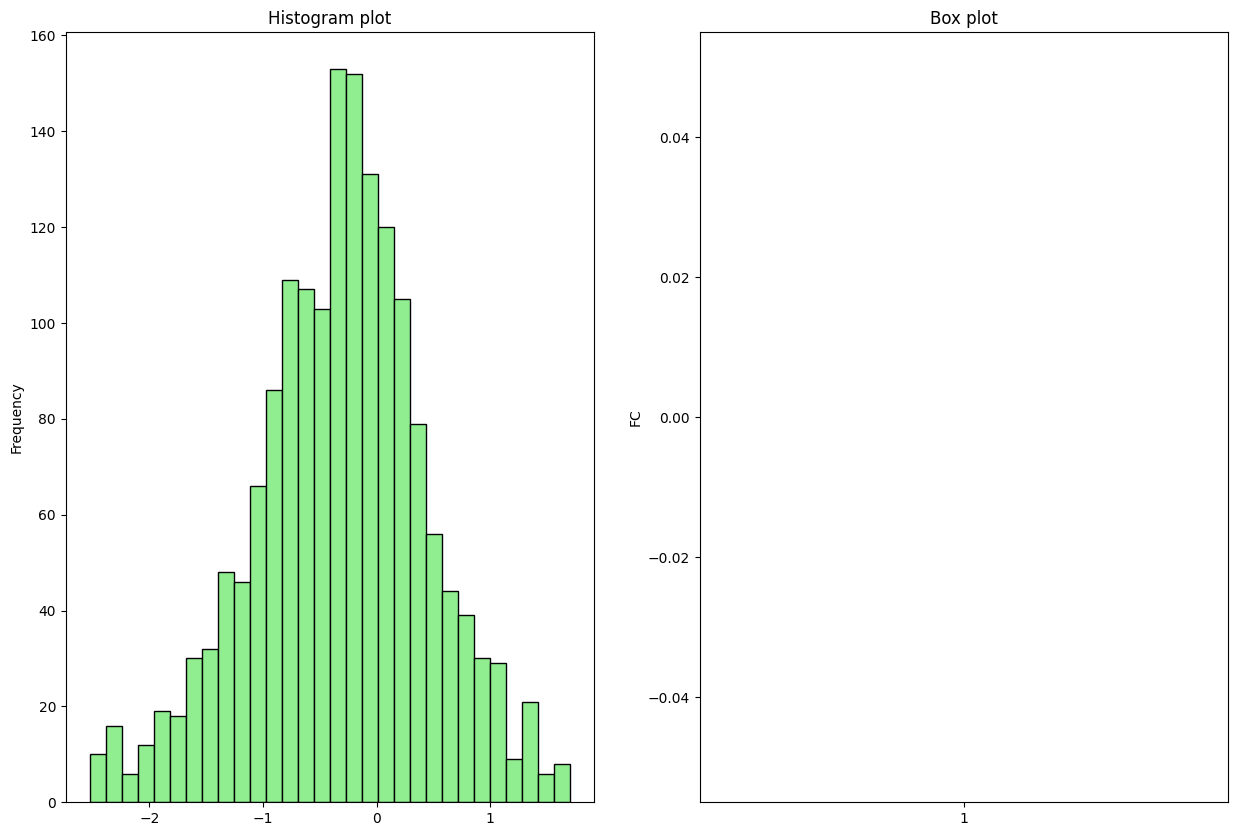

In [120]:
# Boxplot: show boxplot(Q1,Q2,Q3) and filer points(beyond the whis*(IQR = Q3-Q1))
# Histogram Plot: show the distribution of data

print('From the histogram plot, we can see the distribution of FC')
print('From the boxplot, we can identify the filter points(outliers) of FC by IQR')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

data = df_FC_YMD_IQR_good['FC_daily_mean'].tolist()

#create histogram to show the distribution of FC, the y_axis is the frequency of those data
axs[0].hist(data, bins = 30, color='lightgreen', ec='black')
axs[0].set_ylabel('Frequency')  # Add a y-label to the axes.
axs[0].set_title('Histogram plot')

# create a boxplot
axs[1].boxplot(data, whis=1.5, showcaps = True) # set the whist as 2.5, if the value beyond the 1.5*IQR, it will be pointed as filter point
axs[1].set_ylabel('FC')  # Add a y-label to the axes.
axs[1].set_title('Box plot')


plt.show()

##### Monthly Mean of FC
- after IQR

In [29]:
df_FC_YMD_IQR_good_M = df_FC_YMD_IQR_good.groupby(['Year','Month'])['FC_daily_mean'].mean().to_frame()

df_FC_YMD_IQR_good_M.rename(columns= {'FC_daily_mean': 'FC_monthly_mean'}, inplace = True)

df_FC_YMD_IQR_good_M

FC_monthly_mean
Year Month                 
2008 7            -0.199842
     8            -0.081895
     9             0.022229
     10            0.303319
     11           -0.493134
...                     ...
2013 8            -0.572516
     9             0.042211
     10           -0.051666
     11           -0.485250
     12           -0.541258

[66 rows x 1 columns]

In [33]:
df_FC_YMD_IQR_good_M_mean_std = df_FC_YMD_IQR_good_M.reset_index().pivot(index='Year',columns=['Month'], values='FC_monthly_mean').describe().loc[['mean','std']]

df_FC_YMD_IQR_good_M_mean_std

Month,1,2,3,4,5,6,7,8,9,10,11,12
mean,-0.481915,-0.614262,-0.660644,-0.357389,-0.361669,-0.445466,-0.415492,-0.241318,0.010779,0.099914,-0.484383,-0.215654
std,0.183260,0.190886,0.154979,0.220648,0.264826,0.243173,0.247729,0.394439,0.286742,0.371135,0.293700,0.207827


The error bar is unreasonable


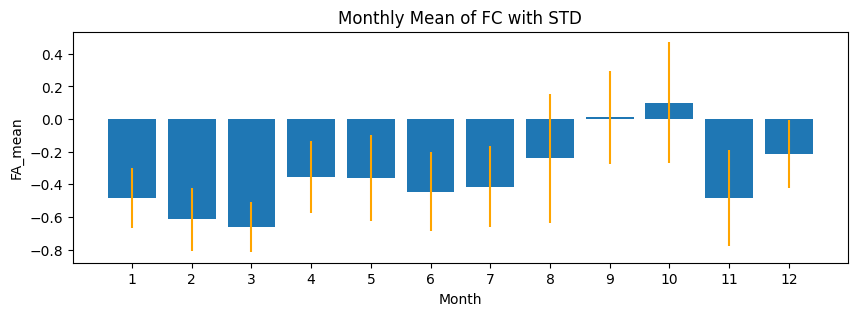

In [34]:
print('The error bar')
# barplot with std

fig, ax = plt.subplots(figsize = (10,3))

ax.bar(df_FC_YMD_IQR_good_M_mean_std.columns, df_FC_YMD_IQR_good_M_mean_std.loc['mean'],
       yerr=df_FC_YMD_IQR_good_M_mean_std.loc['std'], ecolor = 'orange')
ax.set_xticks(df_FC_YMD_IQR_good_M_mean_std.columns)
ax.set_xlabel('Month')
ax.set_ylabel('FA_mean')
ax.set_title('Monthly Mean of FC with STD')

plt.show()


#### Z-score

In [35]:
df_FC_grouped_date

FC_daily_mean
Year Month Day               
2008 7     22       -1.477412
           23        0.182200
           24        0.056240
           25       -0.903600
           26        0.043000
...                       ...
2013 12    18       -0.700537
           19       -0.484568
           20       -0.393629
           21       -1.134333
           22       -1.396588

[1864 rows x 1 columns]

In [130]:
def three_sigma(s):
  mu, std = np.mean(s), np.std(s)
  lower, upper = mu-2.5*std, mu+2.5*std
  return [lower, upper]

FC_daily_mean_checklist = df_FC_grouped_date['FC_daily_mean']
three_sigma_boundary = three_sigma(FC_daily_mean_checklist)
print('The detection boundary based on z-score:', three_sigma_boundary)

The detection boundary based on z-score: [-8.785169555663611, 7.315120077490987]


In [132]:
df_FC_YMD_Zscore_good = df_FC_grouped_date.copy() # it store the data points not beyond the cap
count = 0 # count the number of outliers

df_FC_YMD_Zscore_good.loc[(df_FC_YMD_Zscore_good['FC_daily_mean'] > three_sigma_boundary[1]) | (df_FC_YMD_Zscore_good['FC_daily_mean'] < three_sigma_boundary[0]), 'FC_daily_mean'] = np.nan

# to count the number of outliers
for v in df_FC_grouped_date['FC_daily_mean']:
    if v > three_sigma_boundary[1] or v < three_sigma_boundary[0]:
      count +=1

print('The number of outliers: ', count)

# drop the outliers
df_FC_YMD_Zscore_good

The number of outliers:  34


FC_daily_mean
Year Month Day               
2008 7     22       -1.477412
           23        0.182200
           24        0.056240
           25       -0.903600
           26        0.043000
...                       ...
2013 12    18       -0.700537
           19       -0.484568
           20       -0.393629
           21       -1.134333
           22       -1.396588

[1864 rows x 1 columns]

From the histogram plot, we can see the distribution of FC
From the boxplot, we can identify the filter points(outliers) of FC by IQR


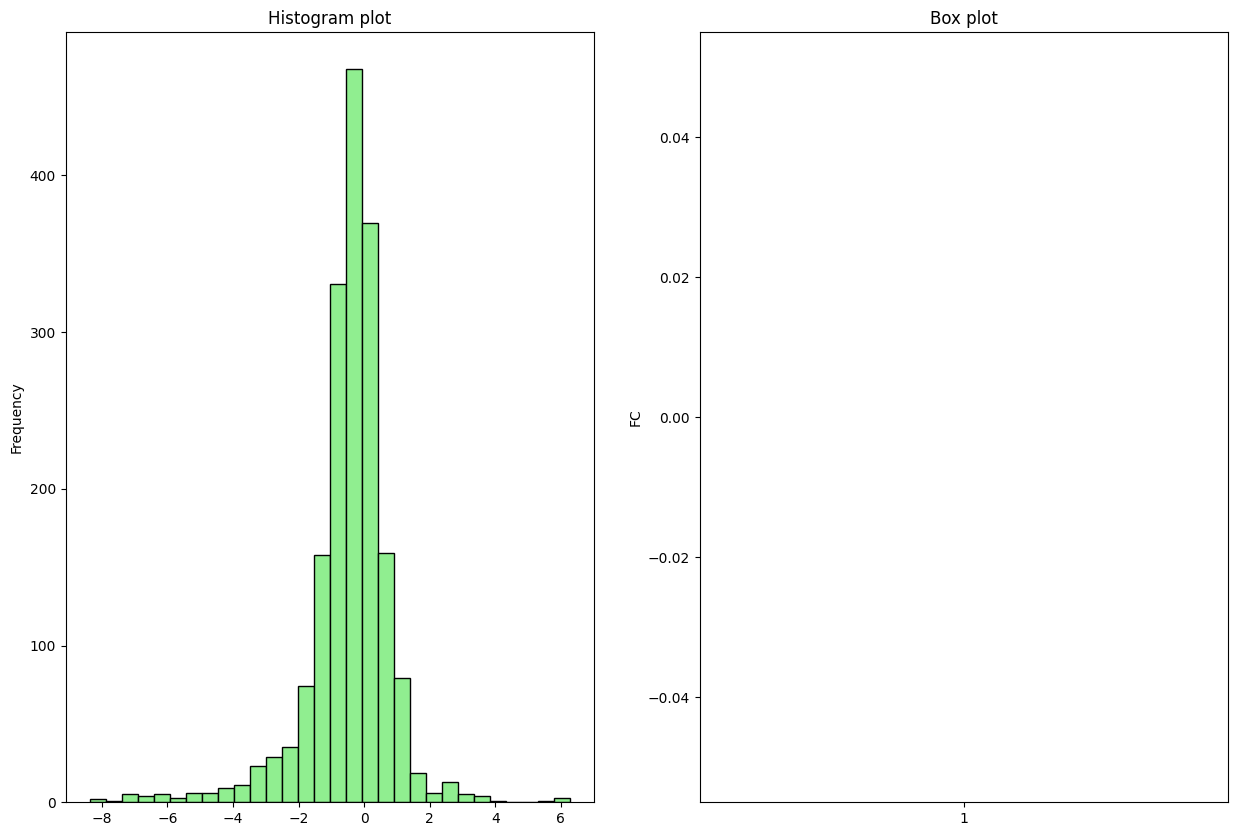

In [133]:
# Boxplot: show boxplot(Q1,Q2,Q3) and filer points(beyond the whis*(IQR = Q3-Q1))
# Histogram Plot: show the distribution of data

print('From the histogram plot, we can see the distribution of FC')
print('From the boxplot, we can identify the filter points(outliers) of FC by IQR')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

data = df_FC_YMD_Zscore_good['FC_daily_mean'].tolist()

#create histogram to show the distribution of FC, the y_axis is the frequency of those data
axs[0].hist(data, bins = 30, color='lightgreen', ec='black')
axs[0].set_ylabel('Frequency')  # Add a y-label to the axes.
axs[0].set_title('Histogram plot')

# create a boxplot
axs[1].boxplot(data, whis=1.5, showcaps = True) # set the whist as 2.5, if the value beyond the 1.5*IQR, it will be pointed as filter point
axs[1].set_ylabel('FC')  # Add a y-label to the axes.
axs[1].set_title('Box plot')

plt.show()

##### Monthly Mean of FC
- after zscore

In [134]:
df_FC_YMD_Zscore_good_M = df_FC_YMD_Zscore_good.groupby(['Year','Month'])['FC_daily_mean'].mean().to_frame()

df_FC_YMD_Zscore_good_M.rename(columns= {'FC_daily_mean': 'FC_monthly_mean'}, inplace = True)

df_FC_YMD_Zscore_good_M

FC_monthly_mean
Year Month                 
2008 7            -0.199842
     8            -0.369896
     9            -0.220122
     10            0.303319
     11           -0.493134
...                     ...
2013 8            -0.736956
     9            -0.203230
     10            0.095108
     11           -0.932420
     12           -0.541258

[66 rows x 1 columns]

In [135]:
df_FC_YMD_Zscore_good_M_mean_std = df_FC_YMD_Zscore_good_M.reset_index().pivot(index='Year',columns=['Month'], values='FC_monthly_mean').describe().loc[['mean','std']]

df_FC_YMD_Zscore_good_M_mean_std

Month,1,2,3,4,5,6,7,8,9,10,11,12
mean,-0.492729,-0.673045,-0.794918,-0.696802,-0.471021,-0.705122,-0.731298,-0.392107,-0.246512,0.166917,-0.584885,-0.266359
std,0.216854,0.205719,0.313883,0.877480,0.322472,0.521666,0.495462,0.630699,0.445611,0.437842,0.325566,0.234457


The error bar is unreasonable


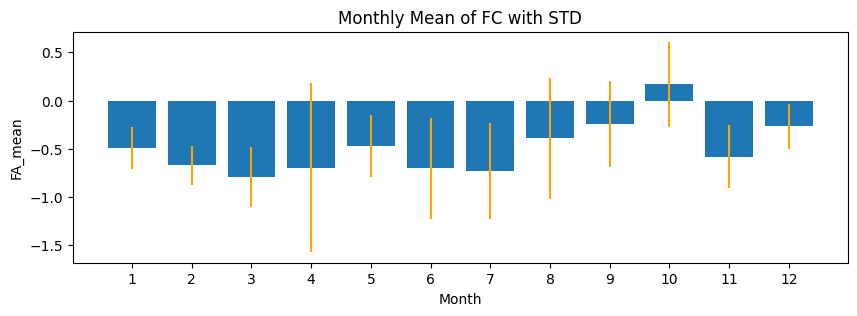

In [136]:
print('The error bar is unreasonable')
# barplot with std

fig, ax = plt.subplots(figsize = (10,3))

ax.bar(df_FC_YMD_Zscore_good_M_mean_std.columns, df_FC_YMD_Zscore_good_M_mean_std.loc['mean'],
       yerr=df_FC_YMD_Zscore_good_M_mean_std.loc['std'], ecolor = 'orange')
ax.set_xticks(df_FC_YMD_Zscore_good_M_mean_std.columns)
ax.set_xlabel('Month')
ax.set_ylabel('FA_mean')
ax.set_title('Monthly Mean of FC with STD')

plt.show()


## Aggregate FC monthly mean into two seasons
- Dry: March - August
- Wet: September - February

In [151]:
df_FC_YMD_Zscore_good_M_mean_std

Month,1,2,3,4,5,6,7,8,9,10,11,12
mean,-0.492729,-0.673045,-0.794918,-0.696802,-0.471021,-0.705122,-0.731298,-0.392107,-0.246512,0.166917,-0.584885,-0.266359
std,0.216854,0.205719,0.313883,0.877480,0.322472,0.521666,0.495462,0.630699,0.445611,0.437842,0.325566,0.234457


In [155]:
df_FC_YMD_Zscore_good_M_mean_std_wet = df_FC_YMD_Zscore_good_M_mean_std[[3,4,5,6,7,8]]
df_FC_YMD_Zscore_good_M_mean_std_dry = df_FC_YMD_Zscore_good_M_mean_std[[9,10,11,12,1,2]]

df_FC_YMD_Zscore_good_M_mean_std_dry

Month,9,10,11,12,1,2
mean,-0.246512,0.166917,-0.584885,-0.266359,-0.492729,-0.673045
std,0.445611,0.437842,0.325566,0.234457,0.216854,0.205719


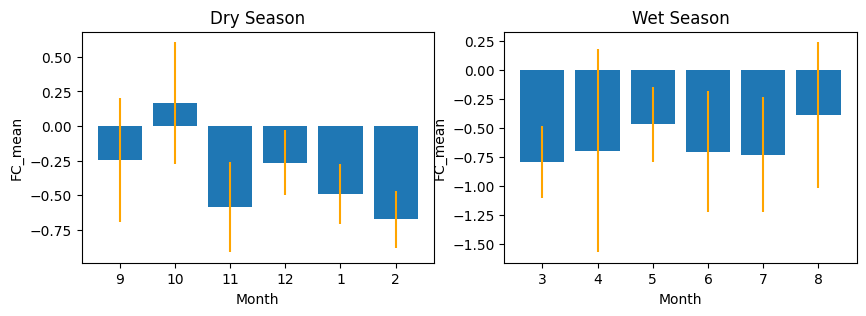

In [156]:
# barplot with std

fig, axes = plt.subplots(1,2,figsize = (10,3))

dry_m = [str(x) for x in df_FC_YMD_Zscore_good_M_mean_std_dry.columns]
dry_m_FC = list(df_FC_YMD_Zscore_good_M_mean_std_dry.loc['mean'])
dry_m_std =list(df_FC_YMD_Zscore_good_M_mean_std_dry.loc['std'])
x_tick = np.arange(0,len(dry_m))  # the label locations

axes[0].bar(dry_m, dry_m_FC,
            yerr=dry_m_std,
            ecolor = 'orange')
axes[0].set_xticks(x_tick, labels = dry_m)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('FC_mean')
axes[0].set_title('Dry Season')


axes[1].bar(df_FC_YMD_Zscore_good_M_mean_std_wet.columns, df_FC_YMD_Zscore_good_M_mean_std_wet.loc['mean'],
       yerr=df_FC_YMD_Zscore_good_M_mean_std_wet.loc['std'], ecolor = 'orange')
axes[1].set_xticks(df_FC_YMD_Zscore_good_M_mean_std_wet.columns)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('FC_mean')
axes[1].set_title('Wet Season')


plt.show()

## by Year-Month

In [60]:
df_FC_grouped_m = df_FC.groupby([df_FC['TIMESTAMP_START'].dt.year,
                              df_FC['TIMESTAMP_START'].dt.month])['FC'].mean().to_frame()
# Rename the index, column
df_FC_grouped_m.index=df_FC_grouped_m.index.rename(['Year','Month'])
df_FC_grouped_m.columns = ['FC_monthly_mean']

In [61]:
# Groupby 'Year','Month'
df_FC_grouped_m

FC_monthly_mean
Year Month                 
2008 7            -0.130588
     8            -0.078827
     9            -0.025933
     10            0.317569
     11           -0.414168
...                     ...
2013 8            -0.658284
     9             0.016813
     10           -1.169380
     11           -0.654491
     12           -0.553732

[66 rows x 1 columns]

In [62]:
# reset index, combine the multiple index in to one index as [Year,Month]

# Flatten the index to columns as level = ['Year','Month'])
df_FC_YM  = df_FC_grouped_m.reset_index(level = ['Year','Month'])

# Create a new colums, then set it as a new index
df_FC_YM['Year_Month'] = [tuple(y_m) for y_m in df_FC_YM[['Year','Month']].values.tolist()]

# Drop the column Year, column Month
df_FC_YM.drop(columns = ['Year', 'Month'], inplace = True)

# df_TA_YM as new DataFrame with Year_Month as index, TA_mean as Value
df_FC_YM

,FC_monthly_mean,Year_Month
0,-0.130588,"(2008, 7)"
1,-0.078827,"(2008, 8)"
2,-0.025933,"(2008, 9)"
3,0.317569,"(2008, 10)"
4,-0.414168,"(2008, 11)"
...,...,...
61,-0.658284,"(2013, 8)"
62,0.016813,"(2013, 9)"
63,-1.169380,"(2013, 10)"
64,-0.654491,"(2013, 11)"


In [76]:
df_FC_YM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FC_monthly_mean  66 non-null     float64
 1   Year_Month       66 non-null     object 
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


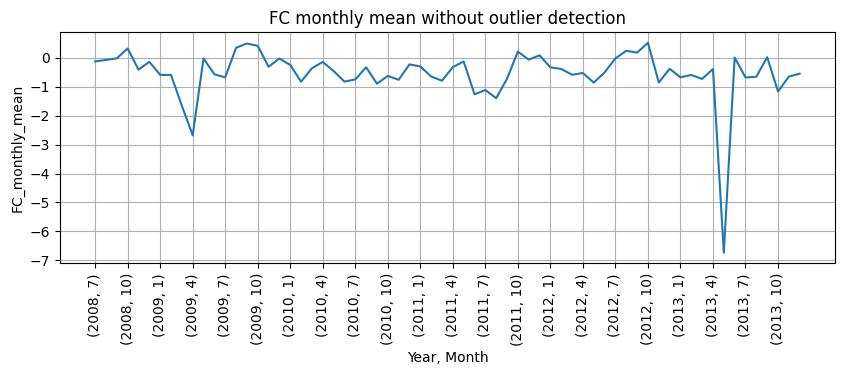

In [75]:
# Plot it as a figure

x_label = df_FC_YM['Year_Month'].tolist()[::3] # the label name
x_tick = np.arange(0, 66,3)  # the label locations

y = df_FC_YM['FC_monthly_mean'].tolist()

fig, ax = plt.subplots(figsize = (10,3))
ax.plot(y)
ax.set_xticks(x_tick)
ax.set_xticklabels(labels=x_label,rotation = 90)
ax.set_xlabel('Year, Month')  # Add an x-label to the axes.
ax.set_ylabel('FC_monthly_mean')  # Add a y-label to the axes.

"""ax.annotate('anomal trend', xy=(54,23.32263829787234), textcoords='offset points',
            arrowprops=dict(facecolor='red', shrink=0.02))"""


ax.set_title("FC monthly mean without outlier detection")  # Add a title to the axes.
ax.grid(True)

plt.show()

### Outlier detection based on Z-score or IQR
- We detect outliers on level of **Monthly mean**
  - FC_mean should be normally distributed cross the entire time
  - IQR is robust to outliers

#### IQR

In [69]:
df_FC_grouped_m

FC_monthly_mean
Year Month                 
2008 7            -0.130588
     8            -0.078827
     9            -0.025933
     10            0.317569
     11           -0.414168
...                     ...
2013 8            -0.658284
     9             0.016813
     10           -1.169380
     11           -0.654491
     12           -0.553732

[66 rows x 1 columns]

In [77]:
df_FC_YM_IQR_good = df_FC_grouped_m.copy() # it store the data points not beyond the cap
count = 0 # count the number of outliers

x_25 = np.percentile(df_FC_YM_IQR_good['FC_monthly_mean'],25)
x_75 = np.percentile(df_FC_YM_IQR_good['FC_monthly_mean'],75)
IQR = x_75 - x_25
whisker = IQR*1.5

df_FC_YM_IQR_good.loc[(df_FC_YM_IQR_good['FC_monthly_mean'] > x_75 + whisker) | (df_FC_YM_IQR_good['FC_monthly_mean'] < x_25 - whisker), 'FC_monthly_mean'] = np.nan

# to count the number of outliers
for v in df_FC_grouped_m['FC_monthly_mean']:
    if v > x_75 + whisker or v < x_25 - whisker:
      count +=1

print('The number of outliers: ', count)

# drop the outliers
df_FC_YM_IQR_good

The number of outliers:  3


FC_monthly_mean
Year Month                 
2008 7            -0.130588
     8            -0.078827
     9            -0.025933
     10            0.317569
     11           -0.414168
...                     ...
2013 8            -0.658284
     9             0.016813
     10           -1.169380
     11           -0.654491
     12           -0.553732

[66 rows x 1 columns]

In [78]:
df_FC_YM_IQR_good.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 66 entries, (2008, 7) to (2013, 12)
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   FC_monthly_mean  63 non-null     float64
dtypes: float64(1)
memory usage: 911.0 bytes


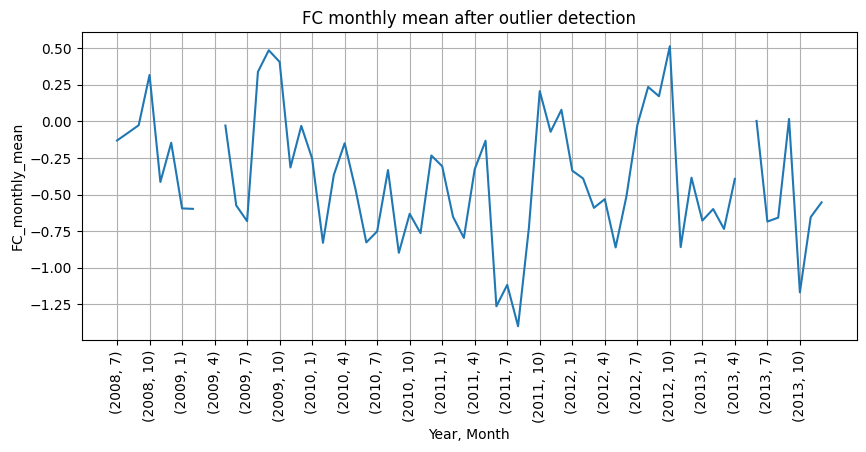

In [105]:
# Plot it as a figure

x_label = df_FC_YM['Year_Month'].tolist()[::3] # the label name
x_tick = np.arange(0, 66,3)  # the label locations

y = df_FC_YM_IQR_good['FC_monthly_mean'].tolist()

fig, axs = plt.subplots(1,1, figsize = (10,4))

axs.plot(y)
axs.set_xticks(x_tick)
axs.set_xticklabels(labels=x_label,rotation = 90)
axs.set_xlabel('Year, Month')  # Add an x-label to the axes.
axs.set_ylabel('FC_monthly_mean')  # Add a y-label to the axes.

"""ax.annotate('anomal trend', xy=(54,23.32263829787234), textcoords='offset points',
            arrowprops=dict(facecolor='red', shrink=0.02))"""
axs.set_title("FC monthly mean after outlier detection")  # Add a title to the axes.
axs.grid(True)

plt.show()

##### Monthly Mean of FC
- after IQR

In [106]:
df_FC_YM_IQR_good.reset_index().pivot(index='Year',columns=['Month'],
                                      values='FC_monthly_mean')

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2008,NaN,NaN,NaN,NaN,NaN,NaN,-0.130588,-0.078827,-0.025933,0.317569,-0.414168,-0.146112
2009,-0.594991,-0.598261,NaN,NaN,-0.028139,-0.575011,-0.682237,0.339356,0.486726,0.407221,-0.314974,-0.030553
2010,-0.253798,-0.830177,-0.366542,-0.149209,-0.463231,-0.827731,-0.751839,-0.332720,-0.898867,-0.632112,-0.764159,-0.233163
2011,-0.306631,-0.652493,-0.796778,-0.327207,-0.132252,-1.264738,-1.118048,-1.401018,-0.727166,0.207405,-0.070915,0.079264
2012,-0.336647,-0.390418,-0.591220,-0.531667,-0.862078,-0.511225,-0.026570,0.235949,0.172224,0.514353,-0.859955,-0.384854
2013,-0.678792,-0.599545,-0.735490,-0.393030,NaN,0.003269,-0.685105,-0.658284,0.016813,-1.169380,-0.654491,-0.553732


In [73]:
df_FC_YM_IQR_good_M_mean_std = df_FC_YM_IQR_good.reset_index().pivot(index='Year',columns=['Month'], values='FC_monthly_mean').describe().loc[['mean','std']]

df_FC_YM_IQR_good_M_mean_std

Month,1,2,3,4,5,6,7,8,9,10,11,12
mean,-0.434172,-0.614179,-0.622508,-0.350278,-0.371425,-0.635087,-0.565731,-0.315924,-0.162701,-0.059157,-0.513110,-0.211525
std,0.189746,0.157050,0.191165,0.158840,0.376040,0.463686,0.411718,0.645770,0.537666,0.681215,0.299299,0.232036


The error bar


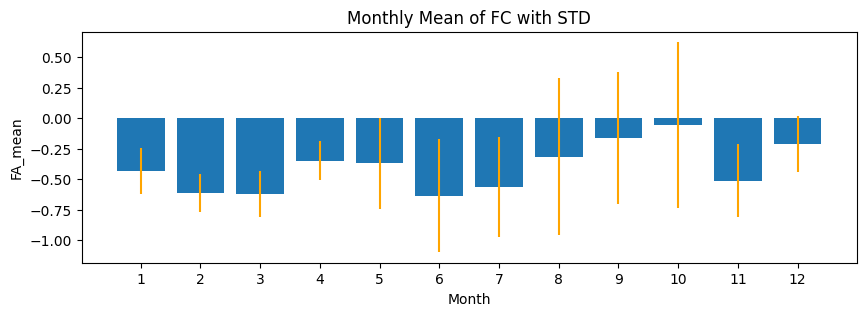

In [74]:
print('The error bar')
# barplot with std

fig, ax = plt.subplots(figsize = (10,3))

ax.bar(df_FC_YM_IQR_good_M_mean_std.columns, df_FC_YM_IQR_good_M_mean_std.loc['mean'],
       yerr=df_FC_YM_IQR_good_M_mean_std.loc['std'], ecolor = 'orange')
ax.set_xticks(df_FC_YM_IQR_good_M_mean_std.columns)
ax.set_xlabel('Month')
ax.set_ylabel('FA_mean')
ax.set_title('Monthly Mean of FC with STD')

plt.show()


#### Z-score

In [83]:
df_FC_grouped_m

FC_monthly_mean
Year Month                 
2008 7            -0.130588
     8            -0.078827
     9            -0.025933
     10            0.317569
     11           -0.414168
...                     ...
2013 8            -0.658284
     9             0.016813
     10           -1.169380
     11           -0.654491
     12           -0.553732

[66 rows x 1 columns]

In [123]:
def three_sigma(s):
  mu, std = np.mean(s), np.std(s)
  lower, upper = mu-2.5*std, mu+2.5*std
  return [lower, upper]

FC_monthly_mean_checklist = df_FC_grouped_m['FC_monthly_mean']
three_sigma_boundary = three_sigma(FC_monthly_mean_checklist)
print('The detection boundary based on z-score:', three_sigma_boundary)

The detection boundary based on z-score: [-2.8651984885669464, 1.7791136773053928]


In [124]:
df_FC_YM_Zscore_good = df_FC_grouped_m.copy() # it store the data points not beyond the cap
count = 0 # count the number of outliers

df_FC_YM_Zscore_good.loc[(df_FC_YM_Zscore_good['FC_monthly_mean'] > three_sigma_boundary[1]) | (df_FC_YM_Zscore_good['FC_monthly_mean'] < three_sigma_boundary[0]), 'FC_monthly_mean'] = np.nan

# to count the number of outliers
for v in df_FC_grouped_m['FC_monthly_mean']:
    if v > three_sigma_boundary[1] or v < three_sigma_boundary[0]:
      count +=1

print('The number of outliers: ', count)

# drop the outliers
df_FC_YM_Zscore_good

The number of outliers:  1


FC_monthly_mean
Year Month                 
2008 7            -0.130588
     8            -0.078827
     9            -0.025933
     10            0.317569
     11           -0.414168
...                     ...
2013 8            -0.658284
     9             0.016813
     10           -1.169380
     11           -0.654491
     12           -0.553732

[66 rows x 1 columns]

##### Monthly Mean of FC
- after zscore

In [125]:
df_FC_YM_Zscore_good_M = df_FC_YMD_Zscore_good.groupby(['Year','Month'])['FC_daily_mean'].mean().to_frame()

df_FC_YM_Zscore_good_M.rename(columns= {'FC_daily_mean': 'FC_monthly_mean'}, inplace = True)

df_FC_YM_Zscore_good_M

FC_monthly_mean
Year Month                 
2008 7            -0.199842
     8            -0.369896
     9            -0.220122
     10            0.303319
     11           -0.493134
...                     ...
2013 8            -0.736956
     9            -0.203230
     10           -0.351993
     11           -0.932420
     12           -0.541258

[66 rows x 1 columns]

In [126]:
df_FC_YMD_Zscore_good_M_mean_std = df_FC_YMD_Zscore_good_M.reset_index().pivot(index='Year',columns=['Month'], values='FC_monthly_mean').describe().loc[['mean','std']]

df_FC_YMD_Zscore_good_M_mean_std

Month,1,2,3,4,5,6,7,8,9,10,11,12
mean,-0.492729,-0.673045,-0.794918,-0.614191,-0.471021,-0.705122,-0.680728,-0.392107,-0.246512,0.092401,-0.584885,-0.266359
std,0.216854,0.205719,0.313883,0.694449,0.322472,0.521666,0.418854,0.630699,0.445611,0.487713,0.325566,0.234457


The error bar is unreasonable


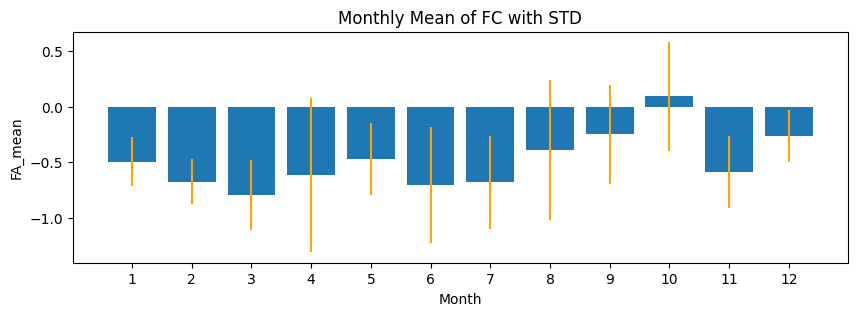

In [127]:
print('The error bar is unreasonable')
# barplot with std

fig, ax = plt.subplots(figsize = (10,3))

ax.bar(df_FC_YMD_Zscore_good_M_mean_std.columns, df_FC_YMD_Zscore_good_M_mean_std.loc['mean'],
       yerr=df_FC_YMD_Zscore_good_M_mean_std.loc['std'], ecolor = 'orange')
ax.set_xticks(df_FC_YMD_Zscore_good_M_mean_std.columns)
ax.set_xlabel('Month')
ax.set_ylabel('FA_mean')
ax.set_title('Monthly Mean of FC with STD')

plt.show()
